For this assignment, use the ERA-5 *monthly mean* data at NCAR (DOI: 10.5065/P8GT-0R61) as we did in Module 2.  Feel free to reduce the data to 1 degree resolution if you need to save data download times.


1) Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and total column water vapor from Jan 1979-Dec 2024 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer. The data and land sea mask is available here: [https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-single-levels-monthly-means?tab=download)


Download ERA5 Monthly Data

In [1]:
# 📦 Import necessary libraries
import cdsapi
import xarray as xr

# 📥 Step 1: Download monthly SST and TCWV from ERA5 (1979–2024) over the Pacific Basin
# This only needs to be run once — comment it out after downloading
c = cdsapi.Client()

c.retrieve(
    'reanalysis-era5-single-levels-monthly-means',
    {
        'variable': ['sea_surface_temperature', 'total_column_water_vapour'],
        'product_type': 'monthly_averaged_reanalysis',
        'year': [str(y) for y in range(1979, 2025)],
        'month': [f'{m:02d}' for m in range(1, 13)],
        'time': '00:00',
        'area': [65, 120, -65, -60],  # North, West, South, East
        'format': 'netcdf',
    },
    'pacific_sst_tcwv_1979_2024.nc'
)

# 🌍 Step 2: Download land-sea mask (only one time slice needed)
c.retrieve(
    'reanalysis-era5-single-levels',
    {
        'variable': 'land_sea_mask',
        'product_type': 'reanalysis',
        'year': '2020',
        'month': '01',
        'day': '01',
        'time': '00:00',
        'area': [65, 120, -65, -60],
        'format': 'netcdf',
    },
    'lsm.nc'
)

# 📂 Step 3: Load the datasets
ds = xr.open_dataset('pacific_sst_tcwv_1979_2024.nc')
ds = ds.rename({'valid_time': 'time'})  # Ensure time dimension is named 'time'
ds = ds.chunk({'time': -1})  # Optional: optimize for performance

lsm = xr.open_dataset('lsm.nc')['lsm'].squeeze()  # Remove time dimension if present

# 🧼 Step 4: Mask out land (keep ocean only where lsm == 0)
sst = ds['sst'].where(lsm == 0)
tcwv = ds['tcwv'].where(lsm == 0)

# 📉 Step 5: Compute monthly SST anomalies (remove monthly climatology)
climatology = sst.groupby('time.month').mean('time')
sst_anomaly = sst.groupby('time.month') - climatology

# 🧩 Step 6: Combine SST anomalies and TCWV into one dataset
ds_combined = xr.Dataset({
    'sst_anomaly': sst_anomaly,
    'tcwv': tcwv
})

# 💾 Step 7: Save the final dataset to NetCDF
ds_combined.to_netcdf('pacific_sst_tcwv_anomalies_masked.nc')


2025-10-11 03:12:01,424 INFO Request ID is a24d3104-6992-417a-a8d4-ed23fdd04272
2025-10-11 03:12:01,612 INFO status has been updated to accepted
2025-10-11 03:12:11,027 INFO status has been updated to successful
2025-10-11 03:12:34,676 INFO Request ID is 9a29ab9b-b1db-4338-96c1-bfee31ea5c7f         
2025-10-11 03:12:34,857 INFO status has been updated to accepted
2025-10-11 03:12:48,920 INFO status has been updated to successful


/home/kiaracr2/envs/xarray-climate/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/kiaracr2/envs/xarray-climate/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/kiaracr2/envs/xarray-climate/lib/python3.13/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/home/kiaracr2/envs/xarray-climate/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/kiaracr2/envs/xarray-climate/lib/python3.13/site-packages/dask/_task_spec.py:759: RuntimeWarning: invalid value encountered in divide
  return self.func(*new_argspec)
/home/kiaracr2/envs/xarray-climate/lib/python3.13/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encount

2)  From the dataset shown in 1, compute anomalies by deseasonalizing the data (remove the mean monthly anomaly from the annual mean from each point) and detrend the data.  

In [2]:
# 📦 Import libraries and functions
import numpy as np
import xarray as xr

# 🧠 Helper: Convert time to float seconds since first timestamp
def _time_as_float(time: xr.DataArray, time_dim: str) -> xr.DataArray:
    return (time - time.isel({time_dim: 0})).astype("timedelta64[s]").astype("int64").astype("float64")

# 📉 Remove linear trend from each grid point
def linear_detrend(obj: xr.DataArray | xr.Dataset, time_dim: str = "time") -> xr.DataArray | xr.Dataset:
    t = _time_as_float(obj[time_dim], time_dim)
    def _detrend_da(da: xr.DataArray) -> xr.DataArray:
        da = da.sortby(time_dim).astype("float32")
        if hasattr(da.data, "chunks"):
            da = da.chunk({time_dim: -1})
        mask = da.notnull()
        t_b = t.broadcast_like(da)
        t_mean_valid = t_b.where(mask).mean(time_dim, skipna=True)
        tc = t_b - t_mean_valid
        num = (da * tc).sum(time_dim, skipna=True)
        den = (tc**2).sum(time_dim, skipna=True)
        slope = xr.where(den > 0, num / den, 0.0)
        ybar = da.mean(time_dim, skipna=True)
        trend = slope * (t_b - t_mean_valid) + ybar
        return (da - trend).astype("float32")
    return obj.map(_detrend_da) if isinstance(obj, xr.Dataset) else _detrend_da(obj)

# 📊 Remove monthly climatology and compute z-scores
def monthly_anom_and_z(
    detr: xr.DataArray | xr.Dataset,
    time_dim: str = "time",
    base_period: tuple[str, str] | None = None,
    ddof: int = 1,
    eps: float = 1e-6,
):
    clim_src = detr if base_period is None else detr.sel({time_dim: slice(*base_period)})
    key = f"{time_dim}.month"
    clim_mean = clim_src.groupby(key).mean(time_dim, skipna=True)
    anom = detr.groupby(key) - clim_mean
    clim_std = clim_src.groupby(key).std(time_dim, skipna=True, ddof=ddof)
    safe_std = xr.where(clim_std > eps, clim_std, np.nan)
    z = anom.groupby(key) / safe_std
    return anom, z

# 📂 Load the masked dataset
ds = xr.open_dataset("pacific_sst_tcwv_anomalies_masked.nc")
ds = ds.chunk({"time": -1})  # Ensure time is a single chunk

# 🧼 Step 1: Process SST anomaly
print("Processing SST anomaly...")
sst_detrended = linear_detrend(ds["sst_anomaly"], time_dim="time")
sst_anom, sst_z = monthly_anom_and_z(sst_detrended, time_dim="time", base_period=("1981-01-01", "2010-12-31"))
sst_anom.to_netcdf("sst_anomaly_deseasonalized.nc")
sst_z.to_netcdf("sst_zscore_detrended.nc")

# 🧼 Step 2: Process TCWV
print("Processing TCWV...")
tcwv_detrended = linear_detrend(ds["tcwv"], time_dim="time")
tcwv_anom, tcwv_z = monthly_anom_and_z(tcwv_detrended, time_dim="time", base_period=("1981-01-01", "2010-12-31"))
tcwv_anom.to_netcdf("tcwv_deseasonalized.nc")
tcwv_z.to_netcdf("tcwv_zscore_detrended.nc")

print("✅ All variables processed and saved.")


Processing SST anomaly...
Processing TCWV...
✅ All variables processed and saved.


3) Perform an EOF analysis on the SST anomalies and plot a map of the first 5 EOFs, following M04N05.

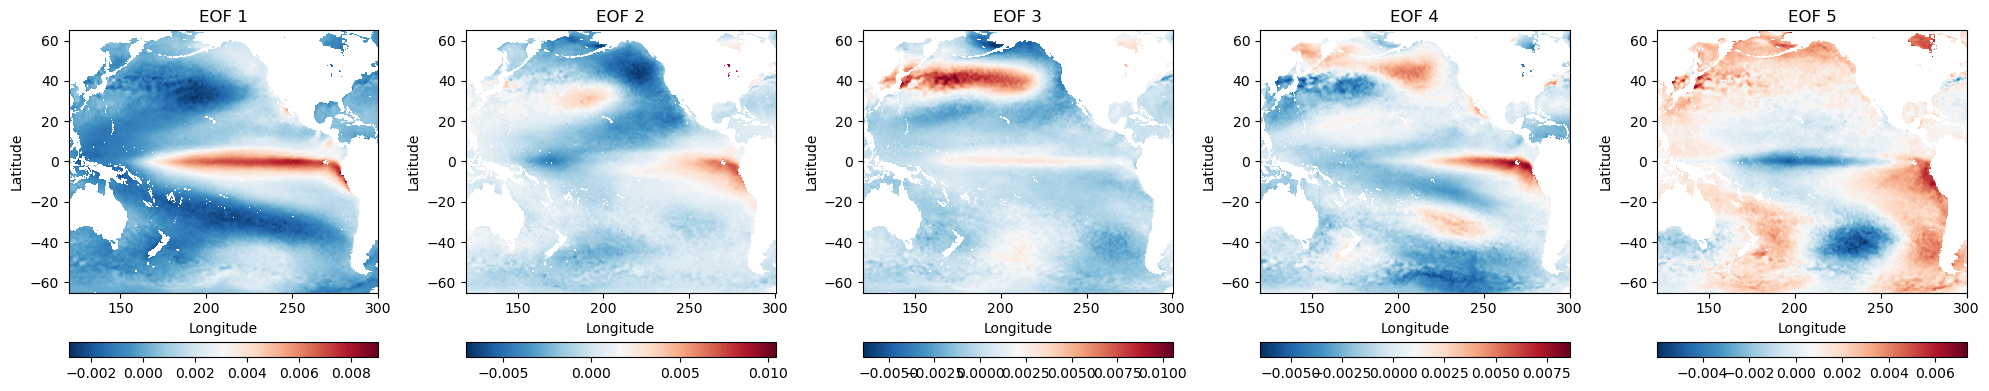

In [3]:
# 📦 Step 1: Import libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# 📂 Step 2: Load SST anomaly as a DataArray
sst = xr.open_dataarray("sst_anomaly_deseasonalized.nc")  # shape: (time, lat, lon)

# 🧼 Step 3: Stack spatial dimensions
sst_2d = sst.stack(space=("latitude", "longitude"))  # shape: (time, space)

# 🧼 Step 4: Drop columns with any NaNs across time
valid_space = ~sst_2d.isnull().any(dim="time")
sst_valid = sst_2d[:, valid_space]  # shape: (time, valid_space)

# 📉 Step 5: Center the data in time (remove mean across time)
sst_centered = sst_valid - sst_valid.mean(dim="time")

# 🔍 Step 6: Apply SVD to compute EOFs
svd = TruncatedSVD(n_components=5)
pcs = svd.fit_transform(sst_centered.fillna(0))  # principal components (time × mode)
eofs = svd.components_                           # EOF patterns (mode × space)

# 🗺️ Step 7: Reshape EOFs back to latitude × longitude
lat = sst.latitude
lon = sst.longitude
eof_template = xr.full_like(sst.isel(time=0), np.nan).stack(space=("latitude", "longitude"))

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i in range(5):
    eof_map = eof_template.copy()
    eof_map.values[valid_space.values] = eofs[i]
    eof_map = eof_map.unstack("space")  # reshape back to (lat, lon)

    im = axs[i].pcolormesh(lon, lat, eof_map, shading="auto", cmap="RdBu_r")
    axs[i].set_title(f"EOF {i+1}")
    axs[i].set_xlabel("Longitude")
    axs[i].set_ylabel("Latitude")
    plt.colorbar(im, ax=axs[i], orientation="horizontal", fraction=0.05)

plt.tight_layout()
plt.show()




4) Plot the percent of variance explained by the first 10 EOFs.

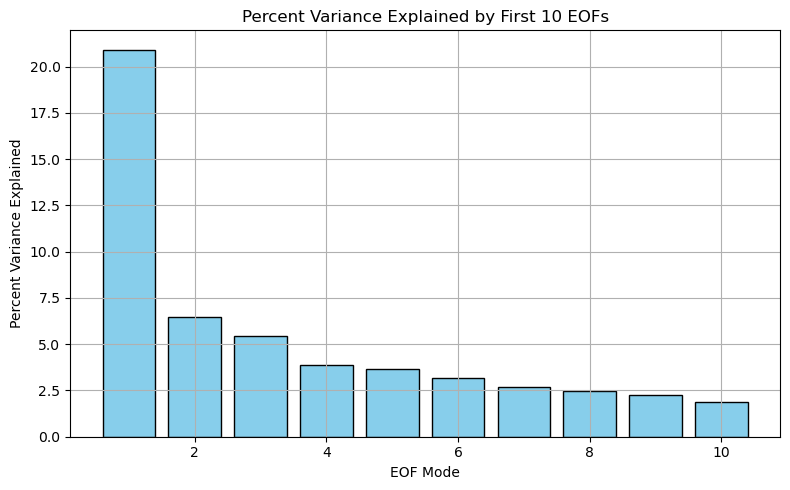

In [4]:
# 📦 Step 1: Import libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# 📂 Step 2: Load SST anomaly as a DataArray
sst = xr.open_dataarray("sst_anomaly_deseasonalized.nc")  # shape: (time, lat, lon)

# 🧼 Step 3: Stack spatial dimensions and drop invalid points
sst_2d = sst.stack(space=("latitude", "longitude"))        # shape: (time, space)
valid_space = ~sst_2d.isnull().any(dim="time")             # keep only complete grid points
sst_valid = sst_2d[:, valid_space]                         # shape: (time, valid_space)

# 📉 Step 4: Center the data in time
sst_centered = sst_valid - sst_valid.mean(dim="time")

# 🔍 Step 5: Apply SVD to compute EOFs
svd = TruncatedSVD(n_components=10)
svd.fit(sst_centered.fillna(0))  # fill NaNs with 0 for SVD

# 📊 Step 6: Plot percent variance explained
explained = svd.explained_variance_ratio_ * 100  # convert to percent

plt.figure(figsize=(8, 5))
plt.bar(range(1, 11), explained, color="skyblue", edgecolor="black")
plt.xlabel("EOF Mode")
plt.ylabel("Percent Variance Explained")
plt.title("Percent Variance Explained by First 10 EOFs")
plt.grid(True)
plt.tight_layout()
plt.show()


5) Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient ([xarray.corr](https://docs.xarray.dev/en/stable/generated/xarray.corr.html)) of the reconstructed monthly time series and the "observed" SST time series.

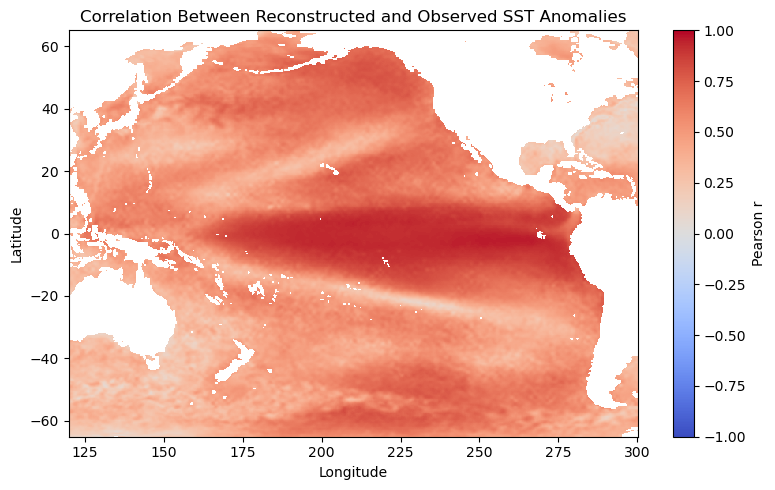

In [5]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# Load SST anomaly
sst = xr.open_dataarray("sst_anomaly_deseasonalized.nc")
sst_2d = sst.stack(space=("latitude", "longitude"))
valid_space = ~sst_2d.isnull().any(dim="time")
sst_valid = sst_2d[:, valid_space]
sst_centered = sst_valid - sst_valid.mean(dim="time")

# EOF analysis (first 5 modes)
svd = TruncatedSVD(n_components=5)
pcs = svd.fit_transform(sst_centered.fillna(0))
eofs = svd.components_
sst_recon = xr.DataArray(
    np.dot(pcs, eofs),
    dims=["time", "space"],
    coords={"time": sst.time, "space": sst_2d.space[valid_space]}
)

# Compute correlation directly in stacked space
corr = xr.corr(sst_valid, sst_recon, dim="time")

# Reshape correlation map to lat/lon
template = xr.full_like(sst.isel(time=0), np.nan).stack(space=("latitude", "longitude"))
template.values[valid_space.values] = corr.values
corr_map = template.unstack("space")

# Plot
plt.figure(figsize=(8, 5))
im = plt.pcolormesh(sst.longitude, sst.latitude, corr_map, shading="auto", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Between Reconstructed and Observed SST Anomalies")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(im, label="Pearson r")
plt.tight_layout()
plt.show()


6) Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean column water vapor anomalies (don't mask these over land for the plot).  See anything interesting? 

/home/kiaracr2/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/kiaracr2/envs/xarray-climate/lib/python3.13/site-packages/numpy/lib/_nanfunctions_impl.py:2015: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


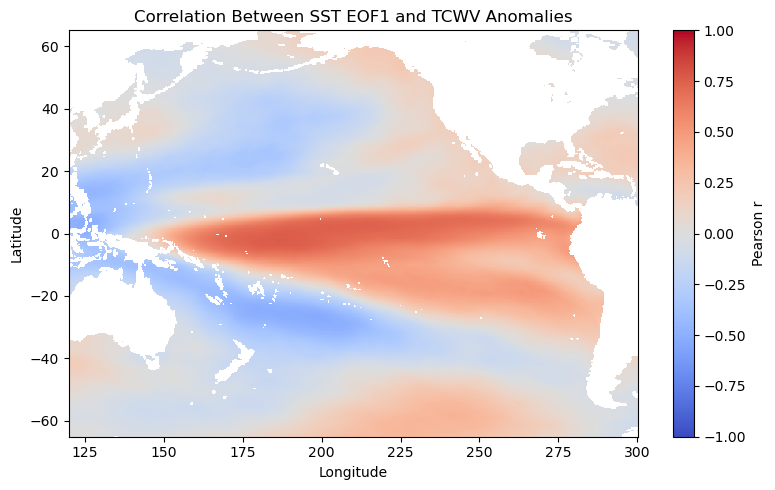

In [6]:
# 📦 Step 1: Import libraries
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD

# 📂 Step 2: Load SST and TCWV anomaly datasets
sst = xr.open_dataarray("sst_anomaly_deseasonalized.nc")  # shape: (time, lat, lon)
tcwv = xr.open_dataarray("tcwv_zscore_detrended.nc")      # shape: (time, lat, lon)

# 🧼 Step 3: Stack SST spatial dimensions and drop invalid points
sst_2d = sst.stack(space=("latitude", "longitude"))
valid_space = ~sst_2d.isnull().any(dim="time")
sst_valid = sst_2d[:, valid_space]

# 📉 Step 4: Center SST data and extract EOF1
sst_centered = sst_valid - sst_valid.mean(dim="time")
svd = TruncatedSVD(n_components=1)
pcs = svd.fit_transform(sst_centered.fillna(0))  # EOF1 time series

# 🔍 Step 5: Create EOF1 as xarray DataArray
eof1_ts = xr.DataArray(pcs[:, 0], dims=["time"], coords={"time": sst.time})

# 📊 Step 6: Compute correlation between EOF1 and TCWV at each grid point
corr_map = xr.corr(tcwv, eof1_ts, dim="time")

# 🗺️ Step 7: Plot correlation map
plt.figure(figsize=(8, 5))
im = plt.pcolormesh(tcwv.longitude, tcwv.latitude, corr_map, shading="auto", cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlation Between SST EOF1 and TCWV Anomalies")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(im, label="Pearson r")
plt.tight_layout()
plt.show()
